<a href="https://colab.research.google.com/github/annkamsk/ASD-problems/blob/master/Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from skimage.morphology import binary_opening, disk, label
import random
%matplotlib inline

## UNet definition

In [0]:
"""
  Used:
  Concatenation
  Downsamplin: pooling
  Upsampling: transposed convolution
"""

class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        seq = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
              ]
        self.seq = nn.Sequential(*seq)

    def forward(self, x):
        return self.seq(x)


class UpConv(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        # up conv
        self.up_mode = up_mode
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_seq = nn.Sequential(
            nn.Conv2d(2 * out_channels,
                     out_channels,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU()  
        )

    def forward(self, from_down, from_up):
        from_up = self.up(from_up)
        out = torch.cat((from_up, from_down), 1)
        return self.conv_seq(out)

class UNet(nn.Module):
    def __init__(self, num_classes=2, in_channels=3, depth=5,
                 wf=6, up_mode='transpose'):
        super(UNet, self).__init__()
        self.up_mode = up_mode
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.wf = wf
        self.depth = depth

        self.down_path = nn.ModuleList()
        for i in range(depth):
          ins = self.in_channels if i == 0 else outs
          outs = 2 ** (self.wf + i)
          self.down_path.append(DownConv(ins, outs))

        self.up_path = nn.ModuleList()
        for i in range(depth - 1):
          ins = outs 
          outs = ins // 2
          self.up_path.append(UpConv(ins, outs, up_mode))

        self.final = nn.Conv2d(outs, num_classes, kernel_size=1)


    def forward(self, x):
        encoder_outs = []
        for i, module in enumerate(self.down_path):
            x = module(x)
            if i < len(self.down_path) - 1:
              encoder_outs.append(x)
              x = F.max_pool2d(x, 2)

        for i, module in enumerate(self.up_path):
          from_down = encoder_outs[-i-1]
          x = module(from_down, x)

        x = self.final(x)
        return x

## Load data

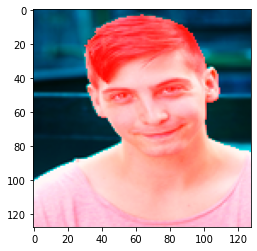

In [34]:
class MyDataset(Dataset):
  def __init__(self, data, mask, transform=True):
    self.data = data
    self.target = np.array([self.__encode__(m) for m in mask])
    self.N = self.data.shape[0]
    self.use_transform = transform
    self.transform = [self.__ident__, self.__rotate90__, self.__rotate270__, self.__horizontal_flip__]

  def __getitem__(self, idx):
    x = self.data[idx % self.N]
    y = self.target[idx % self.N]

    if self.use_transform:
      x, y = self.transform[idx // self.N](x, y)
    else:
      x, y = self.__ident__(x, y)

    return x, y

  def getitem_rotated(self, idx, angle):
    x = self.data[idx % self.N]
    y = self.target[idx % self.N]
    if angle == 90:
      return self.transform[1](x, y)
    return self.transform[2](x, y)

  def getitem_horizontal(self, idx):
    x = self.data[idx % self.N]
    y = self.target[idx % self.N]
    return self.transform[2](x, y)

  def __len__(self):
    return self.N * len(self.transform) if self.use_transform else self.N

  def __encode__(self, mask):
    H, W, _ = mask.shape
    target = np.zeros((H, W))
    target = (mask[:, :, 0] == 255)
    return target.astype(int) 

  def __rotate90__(self, pic, mask):
    return self.__rotate__(pic, mask, 90)
  
  def __rotate270__(self, pic, mask):
    return self.__rotate__(pic, mask, 270)

  def __rotate__(self, pic, mask, angle):
    from skimage.transform import rotate

    for index in range(3):
      channel = pic[:, :, index]
      channel = rotate(channel, angle, resize=False, preserve_range=True)
      pic[:, :, index] = channel

    mask = rotate(mask, angle, resize=False, preserve_range=True)
    return torch.from_numpy(pic), torch.from_numpy(mask).long()

  def __horizontal_flip__(self, pic, mask):
    pic = pic[:,::-1, :].copy()
    mask = mask[:,::-1].copy()
    return torch.from_numpy(pic), torch.from_numpy(mask).long()

  def __ident__(self, pic, mask):
    return torch.from_numpy(pic), torch.from_numpy(mask).long()
      

class Params:
    img_size = (128, 128)
    bs = 2
    num_workers = 4
    lr = 0.001
    epochs = 3
    unet_depth = 5
    wf = 3
    log_interval = 70.0 

train_path = '/content/drive/My Drive/MIM/dl_lab/ass2/gsn_img_uint8.npy'
test_path = '/content/drive/My Drive/MIM/dl_lab/ass2/test_gsn_image.npy'
train_mask = '/content/drive/My Drive/MIM/dl_lab/ass2/gsn_msk_uint8.npy'
test_mask_path = '/content/drive/My Drive/MIM/dl_lab/ass2/test_gsn_mask.npy'
best_model_path = '/content/model.pth'

trains = np.load(train_path)
masks = np.load(train_mask)
tests = np.load(test_path)
test_masks = np.load(test_mask_path)

train_dataset = MyDataset(trains, masks, False)
test_dataset = MyDataset(tests, test_masks, False)
trainloader = DataLoader(train_dataset, 
                         batch_size=Params.bs, 
                         shuffle=True, 
                         pin_memory=torch.cuda.is_available(),
                         num_workers=Params.num_workers)
testloader = DataLoader(test_dataset,
                        batch_size=Params.bs,
                        shuffle=False,
                        pin_memory=torch.cuda.is_available(),
                        num_workers=Params.num_workers)

def imshow(img, target):
  img[:,:,0] = 255 * target
  plt.imshow(img)
  plt.show()

images, targets = iter(trainloader).next()
imshow(images[0], targets[0])

## Train

In [37]:
model = UNet(num_classes=2, depth=Params.unet_depth, wf=Params.wf)
model.cuda()

def get_loss(dataloader, model):
  loss = 0
  total_train = 0
  correct_train = 0
  train_accuracy = 0
  for i, (img, mask) in enumerate(dataloader):
      img, mask = Variable(np.transpose(img.float(), (0,3,1,2))).cuda(), Variable(mask).cuda()
      output = model(img)
      loss += F.cross_entropy(output, mask).item()
      _, predicted = torch.max(output.data, 1)
      total_train += mask.nelement()
      correct_train += predicted.eq(mask.data).sum().item()
      train_accuracy += (100 * correct_train / total_train)
  loss = loss / len(dataloader)
  train_accuracy /= len(dataloader)
  return loss, train_accuracy


def train():
  it = 0
  iters = []
  losses = []
  test_losses = []
  min_loss = np.inf
  ious = []

  criterion = nn.CrossEntropyLoss()
  optim = torch.optim.Adam(model.parameters(), lr=Params.lr)
  
  model.train()
  for epoch in range(Params.epochs):
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for i, (img, mask) in enumerate(trainloader):
      img, mask = Variable(np.transpose(img.float(), (0,3,1,2))).cuda(), Variable(mask).cuda() # [N, 3, H, W] <- [2, 128, 128, 3])
      output = model(img) # [N, 2, 128, 128]
      loss = criterion(output, mask)
      
      optim.zero_grad()
      loss.backward()
      optim.step()

      curr_loss = loss.item()
      running_loss += curr_loss
      if (i + 1) % Params.log_interval == 0:
        it += Params.log_interval * Params.bs
        iters.append(it)
        losses.append(curr_loss)

        print('[%d, %5d] Train loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / Params.log_interval))
        running_loss = 0.0

        model.eval()
        test_loss, accuracy = get_loss(testloader, model)
        model.train()
        test_losses.append(test_loss)
        print('Test pixel accuracy: %d %%' % (accuracy))
        if test_loss < min_loss:
          min_loss = test_loss
          torch.save(model.state_dict(), best_model_path)
        
        mask = mask.cpu().detach().numpy()
        output = output.cpu().detach().numpy()
        intersection = np.logical_and(mask, output)
        union = np.logical_or(mask, output)
        iou_score = np.sum(intersection) / np.sum(union)
        print('IoU score: %.3f' % (iou_score))
        ious.append(iou_score)

  return iters, losses, test_losses, ious
          
iters, losses, test_losses, ious = train()

[1,    70] Train loss: 0.667
Test pixel accuracy: 63 %
IoU score: 0.744
[1,   140] Train loss: 0.493
Test pixel accuracy: 72 %
IoU score: 0.560
[1,   210] Train loss: 0.393
Test pixel accuracy: 74 %
IoU score: 0.315
[1,   280] Train loss: 0.354
Test pixel accuracy: 80 %
IoU score: 0.684
[1,   350] Train loss: 0.315
Test pixel accuracy: 80 %
IoU score: 0.626
[1,   420] Train loss: 0.340
Test pixel accuracy: 80 %
IoU score: 0.682
[1,   490] Train loss: 0.349
Test pixel accuracy: 81 %
IoU score: 0.459
[1,   560] Train loss: 0.325
Test pixel accuracy: 78 %
IoU score: 0.543
[1,   630] Train loss: 0.296
Test pixel accuracy: 80 %
IoU score: 0.749
[1,   700] Train loss: 0.269
Test pixel accuracy: 83 %
IoU score: 0.642
[1,   770] Train loss: 0.285
Test pixel accuracy: 83 %
IoU score: 0.524
[1,   840] Train loss: 0.264
Test pixel accuracy: 83 %
IoU score: 0.663
[1,   910] Train loss: 0.258
Test pixel accuracy: 82 %
IoU score: 0.582
[1,   980] Train loss: 0.242
Test pixel accuracy: 83 %
IoU score

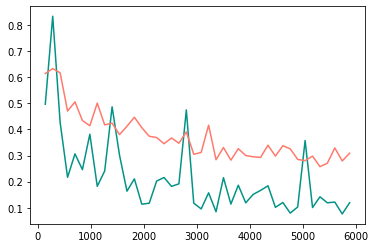

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(iters, losses, color='xkcd:teal')
plt.plot(iters, test_losses, color='xkcd:salmon')
plt.show()
plt.savefig('/content/drive/My Drive/MIM/dl_lab/ass2/batch.png')

## Display some results


In [0]:
net = UNet(num_classes=2, depth=Params.unet_depth, wf=Params.wf)
net.cuda()
net.load_state_dict(torch.load(best_model_path))
test = iter(testloader)
for i in range(10):
  images, targets = test.next()
  img = Variable(np.transpose(images.float(), (0,3,1,2))).cuda()
  output = net(img)
  plt.imshow(images[0])
  plt.show()

  mask = torch.sigmoid(output[0, 0]).data.cpu().numpy()
  mask = binary_opening(mask <= 0.5, disk(2))
  mask = torch.from_numpy(np.array(mask).astype(np.int8))

  imshow(images[0], mask)

## Self-augmentation

In [0]:
model = UNet(num_classes=2, depth=Params.unet_depth, wf=Params.wf)
model.cuda()

def train():
  it = 0
  iters = []
  losses = []
  test_losses = []
  min_loss = np.inf
  ious = []

  criterion = nn.CrossEntropyLoss()
  optim = torch.optim.Adam(model.parameters(), lr=Params.lr)
  
  model.train()
  for epoch in range(Params.epochs):
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for i, (img, mask) in enumerate(trainloader):
      img = Variable(np.transpose(img.float(), (0,3,1,2))).cuda() # [N, 3, H, W] <- [2, 128, 128, 3])
      mask = Variable(mask).cuda() # [N, H, W]
      output = model(img) # [N, 2, 128, 128]
      loss = criterion(output, mask)
      
      optim.zero_grad()
      loss.backward()
      optim.step()

      curr_loss = loss.item()
      running_loss += curr_loss
      if (i + 1) % Params.log_interval == 0:
        it += Params.log_interval * Params.bs
        iters.append(it)
        losses.append(curr_loss)

        print('[%d, %5d] Train loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / Params.log_interval))
        running_loss = 0.0

        model.eval()
        test_loss, accuracy = get_loss(testloader, model)
        model.train()
        test_losses.append(test_loss)
        print('Test pixel accuracy: %d %%' % (accuracy))
        if test_loss < min_loss:
          min_loss = test_loss
          torch.save(model.state_dict(), best_model_path)
        
        mask = mask.cpu().detach().numpy()
        output = output.cpu().detach().numpy()
        intersection = np.logical_and(mask, output)
        union = np.logical_or(mask, output)
        iou_score = np.sum(intersection) / np.sum(union)
        print('IoU score: %d %%' % (iou_score))
        ious.append(iou_score)

  return iters, losses, test_losses, ious
          
iters, losses, test_losses, ious = train()